In [5]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
#import scienceplots
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow.keras.callbacks
from keras import backend as K
from keras.regularizers import l2
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate,GridDistortion,ElasticTransform
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
transforms = Compose([
        ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(p=0.5)])

In [7]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(9, 9))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap = 'bone')
    plt.show()

In [8]:
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = x.astype(np.int32)
    return x

In [9]:
def load_data(x_path, y_path):
    images = os.listdir(x_path)
    masks = os.listdir(y_path)
    
    train_x = [os.path.join(x_path, image) for image in images]
#     train_y = [os.path.join(y_path, mask) for mask in masks]
    
    train_y = list(map(lambda x : x.replace('.jpg', '.tiff'), train_x))
    train_y = list(map(lambda x : x.replace('/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan',
                                            '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks'), train_y))

    
    train_x, valid_x = train_test_split(train_x, test_size=0.15, random_state=0)
    train_y, valid_y = train_test_split(train_y, test_size=0.15, random_state=0)

    return (train_x, train_y), (valid_x, valid_y)


In [10]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size= 5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

def preprocess(x,y):
    
    def aug_fn(image, mask):
        img_data = {"image":image}
        mask_data = {"mask":mask}
        img_data = transforms(**image)
        mask_data = transforms(**mask)
        aug_img = img_data["image"]
        aug_mask = mask_data["mask"]
        return aug_img, aug_mask
    
    def f(x,y):
        x = x.decode()
        y = y.decode()
        
        image = read_image(x)
        mask = read_mask(y)
        augmented = transforms(image=image,mask=mask)
        aug_img=augmented['image']
        aug_mask = augmented['mask']
        
        return aug_img, aug_mask
    
    image, mask = tf.numpy_function(f, [x,y], [tf.float32, tf.int32])
    #image, mask = tf.numpy_function(aug_fn,[image, mask],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, 3, dtype = tf.int32)
    image.set_shape([512,512,3])
    mask.set_shape([512,512,3])
    
    return image, mask

In [11]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def multi_unet_model(n_classes=3, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=3):
  
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)
    s = inputs

    #Encoder path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Decoder path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [12]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_3Class(y_true, y_pred, numLabels=3):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/numLabels

In [13]:
class LossHistory(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

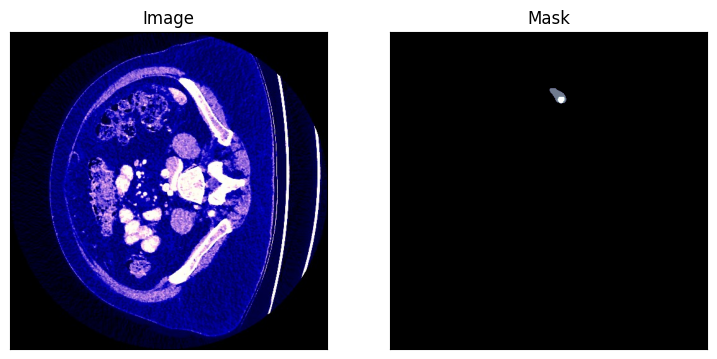

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 512, 512, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

In [15]:
if __name__ == "__main__":
    
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)
    
    i = random.randint(0, 6100)
    
    """ Dataset """
    train_frame_path = '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan'
    train_mask_path = '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan'
    
    (train_x, train_y), (valid_x, valid_y) = load_data(train_frame_path, train_mask_path)
    
    visualize(image = read_image(train_x[i]), mask = read_mask(train_y[i]))
    
    
    #hyperparameters
    IMG_HEIGHT = 512
    IMG_WIDTH = 512
    IMG_CHANNELS = 3
    n_classes = 3
    #weights = [0.35983807, 6.597887, 14.40744607]

    lr = 1e-4
    batch_size = 4
    epochs = 50
    
    """ Model """
    model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
    model.compile(loss='categorical_crossentropy' , optimizer=tf.keras.optimizers.Adam(lr), metrics = ['accuracy', dice_coef_3Class, tf.keras.metrics.OneHotMeanIoU(num_classes=3)] )
    #model.load_weights('/kaggle/input/512x512-multiclass-semantic-unet-vol1-15-weights/Vol1-15_U-Net.h5')
    model.summary()
    
    train_dataset = tf_dataset(train_x, train_y, batch = batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch = batch_size)
    
    train_steps = len(train_x)//batch_size
    valid_steps = len(valid_x)//batch_size
    
    history_class = LossHistory()
    
    callbacks = [
        ModelCheckpoint("Multiclass-Semantic_one_hot_encoder_catcross_U-Net.h5", verbose=1, save_best_model=True),
        ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
        #EarlyStopping(monitor="val_loss", patience=3, verbose=1,min_delta=0.001),
        history_class
    ]

In [16]:
history = model.fit(train_dataset,
                    steps_per_epoch=train_steps,validation_data=valid_dataset,
                    validation_steps=valid_steps,epochs=epochs,
                    callbacks=callbacks,verbose = 1)

model.save('Final_model_Multiclass-Semantic_one_hot_encoder_catcross_U-NET.h5')

Epoch 1/50


2023-11-08 22:00:34.480592: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1526/1526 [==============================] - ETA: 0s - loss: 0.1324 - accuracy: 0.9481 - dice_coef_3Class: 0.5700 - one_hot_mean_io_u_1: 0.5180
Epoch 1: saving model to Multiclass-Semantic_one_hot_encoder_catcross_U-Net.h5
1526/1526 [==============================] - 582s 368ms/step - loss: 0.1324 - accuracy: 0.9481 - dice_coef_3Class: 0.5700 - one_hot_mean_io_u_1: 0.5180 - val_loss: 0.0952 - val_accuracy: 0.9671 - val_dice_coef_3Class: 0.6099 - val_one_hot_mean_io_u_1: 0.5593 - lr: 1.0000e-04
Epoch 2/50
1526/1526 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9761 - dice_coef_3Class: 0.6630 - one_hot_mean_io_u_1: 0.6299
Epoch 2: saving model to Multiclass-Semantic_one_hot_encoder_catcross_U-Net.h5
1526/1526 [==============================] - 489s 319ms/step - loss: 0.0668 - accuracy: 0.9761 - dice_coef_3Class: 0.6630 - one_hot_mean_io_u_1: 0.6299 - val_loss: 0.0619 - val_accuracy: 0.9787 - val_dice_coef_3Class: 0.7015 - val_one_hot_mean_io_u_1: 0.7201 - lr: 1.

In [17]:
hist_df = pd.DataFrame(history.history)

hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


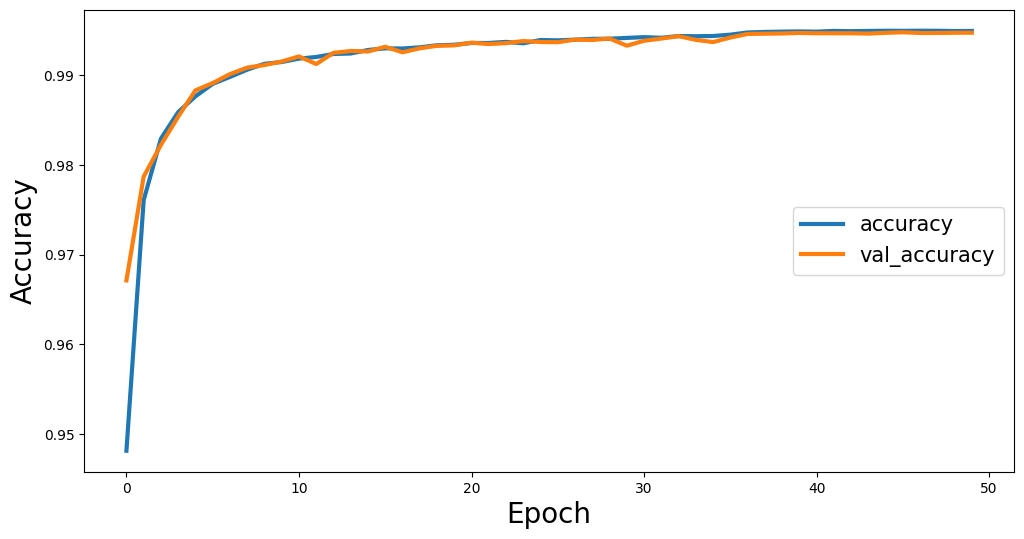

In [18]:
def plot_segm_history_acc(history, metrics=["accuracy", "val_accuracy"], losses=["loss", "val_loss"]):
    #plt.style.use(['science', 'no-latex'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    
    #plt.suptitle("Accuracy V epochs", fontsize=20)
    plt.ylabel("Accuracy", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    # plt.yticks(np.arange(0.3, 1, step=0.02), fontsize=35)
      # plt.xticks(fontsize=35)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

plot_segm_history_acc(history)

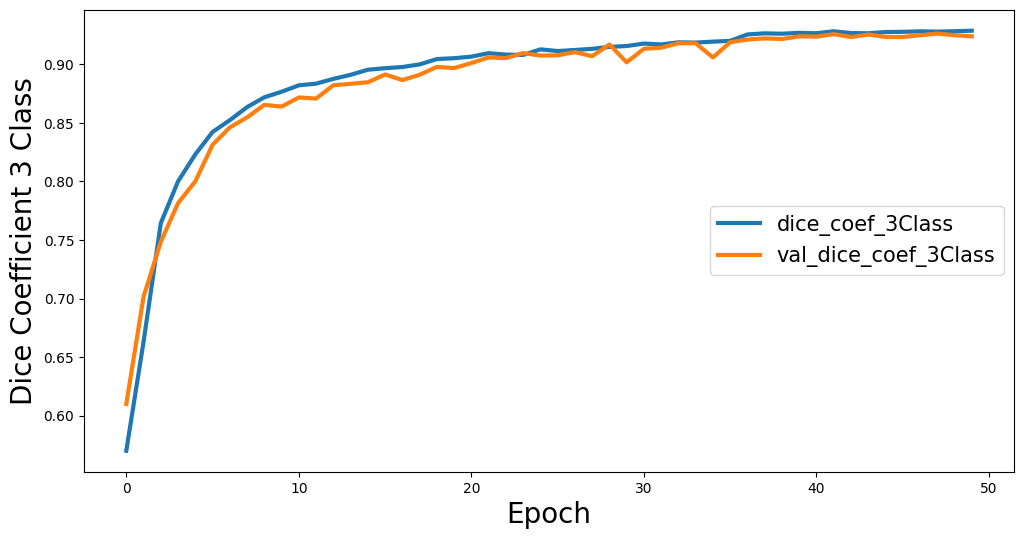

In [19]:
def plot_segm_history_dice(history, metrics=["dice_coef_3Class","val_dice_coef_3Class"], losses=["loss", "val_loss"]):
    #plt.style.use(['science', 'no-latex'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    #plt.suptitle("metrics over epochs", fontsize=20)
    plt.ylabel("Dice Coefficient 3 Class", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    # plt.yticks(np.arange(0.3, 1, step=0.02), fontsize=35)
    # plt.xticks(fontsize=35)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

plot_segm_history_dice(history)

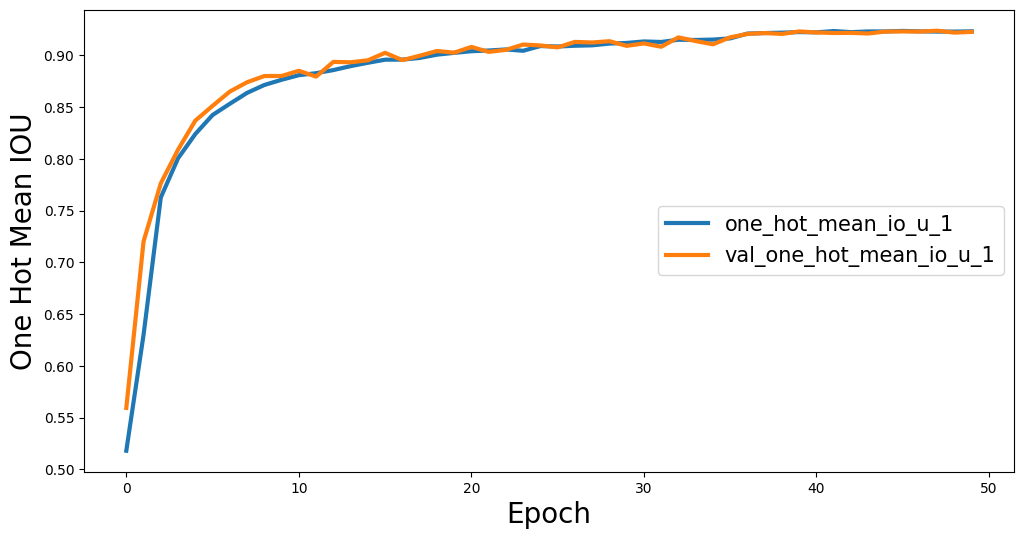

In [21]:
def plot_segm_history_one_hot(history, metrics=["one_hot_mean_io_u_1", "val_one_hot_mean_io_u_1"], losses=["loss", "val_loss"]):
    #plt.style.use(['science', 'no-latex'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    #plt.suptitle("metrics over epochs", fontsize=20)
    plt.ylabel("One Hot Mean IOU", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    # plt.yticks(np.arange(0.3, 1, step=0.02), fontsize=35)
    # plt.xticks(fontsize=35)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

plot_segm_history_one_hot(history)

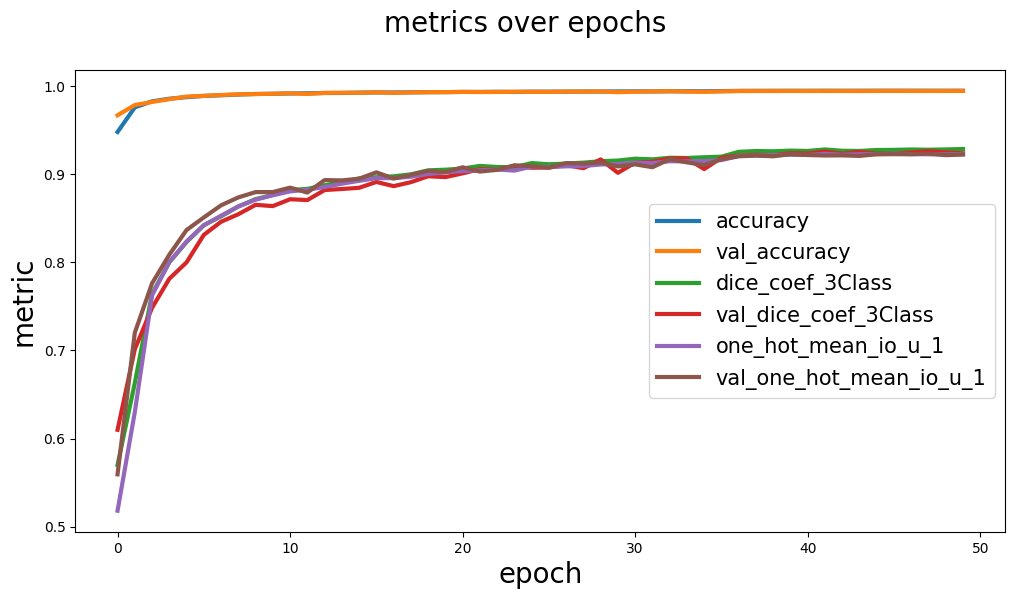

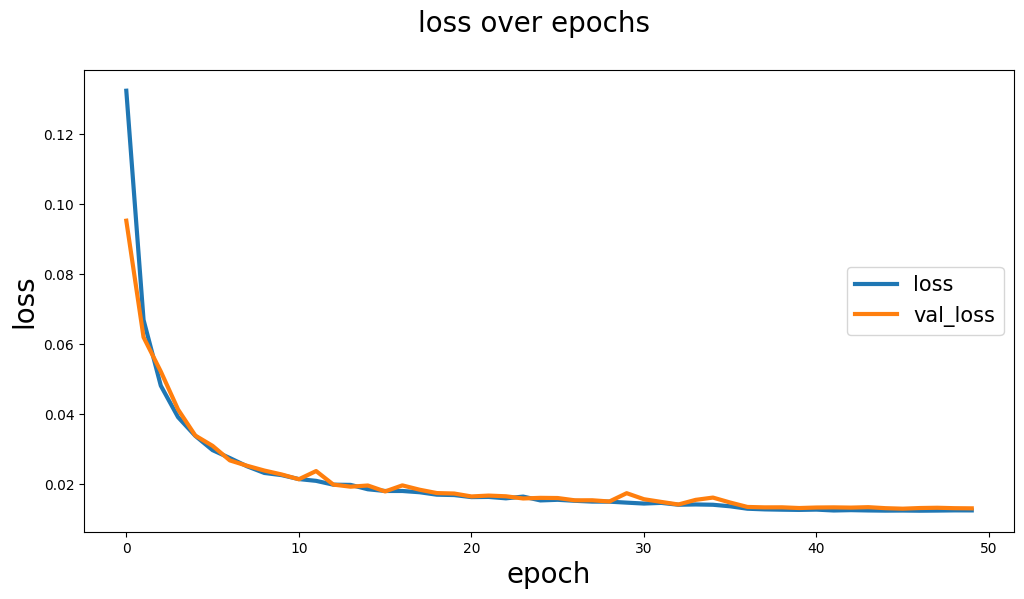

In [22]:
def plot_segm_history(history, metrics=["accuracy", "val_accuracy","dice_coef_3Class","val_dice_coef_3Class", "one_hot_mean_io_u_1", "val_one_hot_mean_io_u_1"], losses=["loss", "val_loss"]):
    #plt.style.use(['science', 'no-latex'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    plt.suptitle("metrics over epochs", fontsize=20)
    plt.ylabel("metric", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    # plt.yticks(np.arange(0.3, 1, step=0.02), fontsize=35)
    # plt.xticks(fontsize=35)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

    plt.figure(figsize=(12, 6))
    for loss in losses:
        plt.plot(history.history[loss], linewidth=3)
    plt.suptitle("loss over epochs", fontsize=20)
    plt.ylabel("loss", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    # plt.yticks(np.arange(0, 0.2, step=0.005), fontsize=35)
    # plt.xticks(fontsize=35)
    plt.legend(losses, loc="center right", fontsize=15)
    plt.show()

plot_segm_history(history)

In [23]:
os.mkdir('./val_masks')
os.listdir('./')

['Final_model_Multiclass-Semantic_one_hot_encoder_catcross_U-NET.h5',
 'history.csv',
 'val_masks',
 'Multiclass-Semantic_one_hot_encoder_catcross_U-Net.h5',
 '.virtual_documents']

In [24]:
from tqdm import tqdm
from PIL import Image

for x in tqdm(valid_x, total = len(valid_x), position = 0, leave=True):
    name = x.split('/')[-1]
    name = name.replace('.jpg', '.tiff')
        
    x = read_image(x)
        
    p = model.predict(np.expand_dims(x,axis=0))[0]
    p = np.argmax(p, axis=-1)
    #print(np.unique(p, return_counts=True))
    p = np.expand_dims(p, axis=-1)
    p = p.astype(np.int32)
    p = np.squeeze(p, axis=-1)
        
    img = Image.fromarray(p.astype('uint8'), mode = 'L')
    img.save(f"./val_masks/{name}")

  0%|          | 0/1078 [00:00<?, ?it/s]

1/1 [==============================] - 0s 334ms/step


  0%|          | 1/1078 [00:00<08:35,  2.09it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 3/1078 [00:00<03:22,  5.32it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 5/1078 [00:00<02:23,  7.47it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 7/1078 [00:00<02:00,  8.89it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 9/1078 [00:01<01:48,  9.84it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 11/1078 [00:01<01:42, 10.41it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 13/1078 [00:01<01:38, 10.86it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 15/1078 [00:01<01:34, 11.28it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 17/1078 [00:01<01:31, 11.55it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 19/1078 [00:01<01:30, 11.67it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 21/1078 [00:02<01:29, 11.78it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 23/1078 [00:02<01:28, 11.90it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 25/1078 [00:02<01:27, 12.09it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 27/1078 [00:02<01:26, 12.09it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 29/1078 [00:02<01:27, 11.99it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 31/1078 [00:02<01:28, 11.80it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 33/1078 [00:03<01:27, 11.99it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 35/1078 [00:03<01:26, 12.04it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 37/1078 [00:03<01:26, 12.00it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 39/1078 [00:03<01:26, 12.01it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 41/1078 [00:03<01:26, 12.05it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 43/1078 [00:03<01:26, 11.91it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 45/1078 [00:04<01:29, 11.51it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 47/1078 [00:04<01:27, 11.78it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 49/1078 [00:04<01:26, 11.94it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 51/1078 [00:04<01:26, 11.83it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 53/1078 [00:04<01:26, 11.84it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 55/1078 [00:05<01:26, 11.84it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 57/1078 [00:05<01:25, 11.98it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 59/1078 [00:05<01:24, 12.04it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 61/1078 [00:05<01:24, 12.08it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 63/1078 [00:05<01:25, 11.89it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 65/1078 [00:05<01:26, 11.77it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 67/1078 [00:06<01:24, 11.97it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 69/1078 [00:06<01:23, 12.08it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 71/1078 [00:06<01:22, 12.17it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 73/1078 [00:06<01:24, 11.95it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 75/1078 [00:06<01:24, 11.80it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 77/1078 [00:06<01:24, 11.91it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 79/1078 [00:07<01:24, 11.84it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 81/1078 [00:07<01:24, 11.75it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 83/1078 [00:07<01:24, 11.81it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 85/1078 [00:07<01:23, 11.96it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 87/1078 [00:07<01:22, 12.01it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 89/1078 [00:07<01:21, 12.13it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 91/1078 [00:08<01:21, 12.04it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 93/1078 [00:08<01:21, 12.11it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 95/1078 [00:08<01:21, 12.05it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 97/1078 [00:08<01:20, 12.11it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 99/1078 [00:08<01:21, 12.03it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 101/1078 [00:08<01:21, 12.03it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 103/1078 [00:09<01:21, 11.98it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 105/1078 [00:09<01:20, 12.02it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 107/1078 [00:09<01:20, 12.08it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 109/1078 [00:09<01:21, 11.92it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 111/1078 [00:09<01:20, 12.00it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 113/1078 [00:09<01:19, 12.09it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 115/1078 [00:10<01:20, 11.91it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 117/1078 [00:10<01:22, 11.62it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 119/1078 [00:10<01:21, 11.72it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 121/1078 [00:10<01:20, 11.95it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 123/1078 [00:10<01:19, 12.04it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 125/1078 [00:10<01:18, 12.07it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 127/1078 [00:11<01:19, 11.99it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 129/1078 [00:11<01:18, 12.07it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 131/1078 [00:11<01:18, 12.12it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 133/1078 [00:11<01:18, 11.99it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 135/1078 [00:11<01:20, 11.71it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 137/1078 [00:11<01:20, 11.66it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 139/1078 [00:12<01:19, 11.86it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 141/1078 [00:12<01:18, 11.96it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 143/1078 [00:12<01:17, 12.05it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 145/1078 [00:12<01:17, 11.96it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 147/1078 [00:12<01:17, 11.98it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 149/1078 [00:12<01:17, 11.95it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 151/1078 [00:13<01:17, 11.96it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 153/1078 [00:13<01:18, 11.86it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 155/1078 [00:13<01:17, 11.86it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 157/1078 [00:13<01:16, 12.03it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 159/1078 [00:13<01:16, 12.09it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 161/1078 [00:13<01:15, 12.07it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 163/1078 [00:14<01:16, 11.94it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 165/1078 [00:14<01:16, 11.94it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 167/1078 [00:14<01:15, 12.03it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 169/1078 [00:14<01:15, 12.04it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 171/1078 [00:14<01:15, 11.95it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 173/1078 [00:14<01:15, 11.98it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 175/1078 [00:15<01:15, 12.01it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 177/1078 [00:15<01:15, 11.95it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 179/1078 [00:15<01:14, 12.00it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 181/1078 [00:15<01:15, 11.92it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 183/1078 [00:15<01:13, 12.15it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 185/1078 [00:15<01:13, 12.21it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 187/1078 [00:16<01:14, 12.02it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 189/1078 [00:16<01:14, 11.90it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 191/1078 [00:16<01:14, 11.94it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 193/1078 [00:16<01:13, 12.08it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 195/1078 [00:16<01:13, 12.01it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 197/1078 [00:16<01:13, 11.95it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 199/1078 [00:17<01:14, 11.76it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 201/1078 [00:17<01:14, 11.73it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 203/1078 [00:17<01:16, 11.46it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 205/1078 [00:17<01:16, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 207/1078 [00:17<01:24, 10.30it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 209/1078 [00:17<01:20, 10.74it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 211/1078 [00:18<01:19, 10.91it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 213/1078 [00:18<01:16, 11.24it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 215/1078 [00:18<01:15, 11.46it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 217/1078 [00:18<01:16, 11.30it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 219/1078 [00:18<01:15, 11.36it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 221/1078 [00:19<01:14, 11.55it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 223/1078 [00:19<01:12, 11.77it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 225/1078 [00:19<01:12, 11.70it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 227/1078 [00:19<01:11, 11.91it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 229/1078 [00:19<01:10, 12.01it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 231/1078 [00:19<01:11, 11.92it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 233/1078 [00:20<01:13, 11.55it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 235/1078 [00:20<01:14, 11.32it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 237/1078 [00:20<01:13, 11.50it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 239/1078 [00:20<01:12, 11.65it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 241/1078 [00:20<01:11, 11.79it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 243/1078 [00:20<01:11, 11.73it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 245/1078 [00:21<01:10, 11.89it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 247/1078 [00:21<01:08, 12.09it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 249/1078 [00:21<01:08, 12.14it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 251/1078 [00:21<01:08, 12.07it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 253/1078 [00:21<01:09, 11.84it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 255/1078 [00:21<01:09, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 257/1078 [00:22<01:10, 11.59it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 259/1078 [00:22<01:11, 11.46it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 261/1078 [00:22<01:11, 11.47it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 263/1078 [00:22<01:10, 11.60it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 265/1078 [00:22<01:09, 11.70it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 267/1078 [00:22<01:08, 11.87it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 269/1078 [00:23<01:08, 11.88it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 271/1078 [00:23<01:08, 11.73it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 273/1078 [00:23<01:07, 11.95it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 275/1078 [00:23<01:06, 12.00it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 277/1078 [00:23<01:06, 12.03it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 279/1078 [00:23<01:07, 11.87it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 281/1078 [00:24<01:06, 12.00it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 283/1078 [00:24<01:05, 12.11it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 285/1078 [00:24<01:05, 12.09it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 287/1078 [00:24<01:05, 12.12it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 289/1078 [00:24<01:06, 11.80it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 291/1078 [00:24<01:06, 11.90it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 293/1078 [00:25<01:06, 11.83it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 295/1078 [00:25<01:05, 11.87it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 297/1078 [00:25<01:06, 11.72it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 299/1078 [00:25<01:06, 11.70it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 301/1078 [00:25<01:06, 11.68it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 303/1078 [00:25<01:05, 11.78it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 305/1078 [00:26<01:05, 11.81it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 307/1078 [00:26<01:14, 10.39it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 309/1078 [00:26<01:10, 10.89it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 311/1078 [00:26<01:08, 11.24it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 313/1078 [00:26<01:07, 11.41it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 315/1078 [00:27<01:06, 11.42it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 317/1078 [00:27<01:05, 11.58it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 319/1078 [00:27<01:04, 11.74it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 321/1078 [00:27<01:03, 11.95it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 323/1078 [00:27<01:02, 12.00it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 325/1078 [00:27<01:03, 11.95it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 327/1078 [00:28<01:02, 12.02it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 329/1078 [00:28<01:02, 12.03it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 331/1078 [00:28<01:01, 12.18it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 333/1078 [00:28<01:02, 11.97it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 335/1078 [00:28<01:02, 11.97it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 337/1078 [00:28<01:02, 11.81it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 339/1078 [00:29<01:01, 11.94it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 341/1078 [00:29<01:01, 11.91it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 343/1078 [00:29<01:02, 11.83it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 345/1078 [00:29<01:01, 11.98it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 347/1078 [00:29<01:00, 12.04it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 349/1078 [00:29<01:00, 12.10it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 351/1078 [00:30<01:01, 11.73it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 353/1078 [00:30<01:01, 11.77it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 355/1078 [00:30<01:00, 11.87it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 357/1078 [00:30<01:00, 12.00it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 359/1078 [00:30<01:00, 11.98it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 361/1078 [00:30<01:00, 11.88it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 363/1078 [00:31<00:59, 11.97it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 365/1078 [00:31<00:58, 12.12it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 367/1078 [00:31<00:59, 12.02it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 369/1078 [00:31<00:59, 11.95it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 371/1078 [00:31<00:58, 12.11it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 373/1078 [00:31<00:57, 12.22it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 375/1078 [00:32<00:57, 12.27it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 377/1078 [00:32<00:57, 12.11it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 379/1078 [00:32<00:58, 11.88it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 381/1078 [00:32<00:58, 11.98it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 383/1078 [00:32<00:57, 12.09it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 385/1078 [00:32<00:57, 12.10it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 387/1078 [00:33<00:57, 12.05it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 389/1078 [00:33<00:57, 11.97it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 391/1078 [00:33<00:57, 11.97it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▋      | 393/1078 [00:33<00:56, 12.03it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 395/1078 [00:33<00:57, 11.95it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 397/1078 [00:33<00:57, 11.86it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 399/1078 [00:34<00:57, 11.87it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 401/1078 [00:34<00:56, 12.02it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 403/1078 [00:34<00:56, 12.05it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 405/1078 [00:34<00:56, 11.93it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 407/1078 [00:34<00:56, 11.92it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 409/1078 [00:34<00:56, 11.94it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 411/1078 [00:35<00:55, 12.08it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 413/1078 [00:35<00:55, 12.09it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 415/1078 [00:35<00:55, 11.88it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▊      | 417/1078 [00:35<00:54, 12.05it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 419/1078 [00:35<00:54, 12.13it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 421/1078 [00:35<00:54, 12.12it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 423/1078 [00:36<00:54, 11.96it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 425/1078 [00:36<00:54, 11.92it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 427/1078 [00:36<00:54, 11.99it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 429/1078 [00:36<00:53, 12.15it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 431/1078 [00:36<00:52, 12.22it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 433/1078 [00:36<00:53, 12.12it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 435/1078 [00:37<00:52, 12.18it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 437/1078 [00:37<00:53, 12.08it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 439/1078 [00:37<00:53, 12.02it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 441/1078 [00:37<00:52, 12.04it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 443/1078 [00:37<00:52, 12.12it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 445/1078 [00:37<00:51, 12.22it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 447/1078 [00:37<00:51, 12.25it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 449/1078 [00:38<00:51, 12.24it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 451/1078 [00:38<00:51, 12.14it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 453/1078 [00:38<00:52, 12.00it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 455/1078 [00:38<00:51, 12.14it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 457/1078 [00:38<00:51, 12.07it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 459/1078 [00:38<00:51, 12.03it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 461/1078 [00:39<00:50, 12.15it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 463/1078 [00:39<00:50, 12.09it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 465/1078 [00:39<00:50, 12.08it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 467/1078 [00:39<00:50, 12.02it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 469/1078 [00:39<00:50, 11.99it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 471/1078 [00:39<00:51, 11.88it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 473/1078 [00:40<00:51, 11.84it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 475/1078 [00:40<00:50, 12.04it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 477/1078 [00:40<00:50, 12.01it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 479/1078 [00:40<00:49, 12.04it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 481/1078 [00:40<00:49, 12.13it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 483/1078 [00:40<00:48, 12.20it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 485/1078 [00:41<00:48, 12.32it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 487/1078 [00:41<00:48, 12.08it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 489/1078 [00:41<00:49, 12.02it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 491/1078 [00:41<00:48, 12.02it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 493/1078 [00:41<00:49, 11.90it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 495/1078 [00:41<00:49, 11.69it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 497/1078 [00:42<00:49, 11.73it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 499/1078 [00:42<00:48, 11.89it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 501/1078 [00:42<00:48, 11.99it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 503/1078 [00:42<00:47, 12.05it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 505/1078 [00:42<00:48, 11.81it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 507/1078 [00:43<00:48, 11.89it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 509/1078 [00:43<00:47, 11.97it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 511/1078 [00:43<00:46, 12.07it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 513/1078 [00:43<00:47, 11.97it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 515/1078 [00:43<00:46, 12.03it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 517/1078 [00:43<00:46, 12.13it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 519/1078 [00:43<00:45, 12.29it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 521/1078 [00:44<00:45, 12.20it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 523/1078 [00:44<00:46, 11.82it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 525/1078 [00:44<00:45, 12.05it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 527/1078 [00:44<00:45, 12.12it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 529/1078 [00:44<00:45, 12.13it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 531/1078 [00:44<00:45, 11.90it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 533/1078 [00:45<00:45, 11.94it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 535/1078 [00:45<00:45, 12.01it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 537/1078 [00:45<00:44, 12.13it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 539/1078 [00:45<00:46, 11.70it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 541/1078 [00:45<00:46, 11.52it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 543/1078 [00:46<00:46, 11.53it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 545/1078 [00:46<00:46, 11.58it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 547/1078 [00:46<00:45, 11.80it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 549/1078 [00:46<00:45, 11.74it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 551/1078 [00:46<00:45, 11.67it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 553/1078 [00:46<00:44, 11.90it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 555/1078 [00:47<00:43, 11.95it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 557/1078 [00:47<00:43, 11.93it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 559/1078 [00:47<00:43, 11.84it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 561/1078 [00:47<00:43, 11.98it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 563/1078 [00:47<00:42, 12.00it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 565/1078 [00:47<00:42, 12.16it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 567/1078 [00:48<00:42, 11.89it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 569/1078 [00:48<00:42, 11.97it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 571/1078 [00:48<00:42, 12.00it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 573/1078 [00:48<00:42, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 575/1078 [00:48<00:44, 11.37it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 577/1078 [00:48<00:45, 11.04it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 579/1078 [00:49<00:44, 11.12it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 581/1078 [00:49<00:43, 11.42it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 583/1078 [00:49<00:42, 11.54it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 585/1078 [00:49<00:43, 11.42it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 587/1078 [00:49<00:42, 11.52it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 589/1078 [00:49<00:42, 11.55it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 591/1078 [00:50<00:42, 11.42it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 593/1078 [00:50<00:42, 11.51it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 595/1078 [00:50<00:41, 11.56it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 597/1078 [00:50<00:40, 11.73it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 599/1078 [00:50<00:40, 11.76it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 601/1078 [00:50<00:39, 11.95it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 603/1078 [00:51<00:39, 11.92it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 605/1078 [00:51<00:39, 11.98it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 607/1078 [00:51<00:39, 12.05it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 609/1078 [00:51<00:40, 11.50it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 611/1078 [00:51<00:41, 11.28it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 613/1078 [00:52<00:41, 11.15it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 615/1078 [00:52<00:41, 11.20it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 617/1078 [00:52<00:41, 11.18it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 619/1078 [00:52<00:40, 11.40it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 621/1078 [00:52<00:40, 11.23it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 623/1078 [00:52<00:40, 11.11it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 625/1078 [00:53<00:40, 11.22it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 627/1078 [00:53<00:40, 11.27it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 629/1078 [00:53<00:39, 11.35it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 631/1078 [00:53<00:39, 11.30it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 633/1078 [00:53<00:39, 11.39it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 635/1078 [00:53<00:38, 11.48it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 637/1078 [00:54<00:37, 11.76it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 639/1078 [00:54<00:37, 11.63it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 641/1078 [00:54<00:37, 11.66it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 643/1078 [00:54<00:36, 11.79it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 645/1078 [00:54<00:36, 11.90it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 647/1078 [00:54<00:36, 11.95it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 649/1078 [00:55<00:36, 11.90it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 651/1078 [00:55<00:36, 11.83it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 653/1078 [00:55<00:35, 11.89it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 655/1078 [00:55<00:35, 11.89it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 657/1078 [00:55<00:35, 11.75it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 659/1078 [00:55<00:35, 11.86it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 661/1078 [00:56<00:34, 11.96it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 663/1078 [00:56<00:34, 12.06it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 665/1078 [00:56<00:33, 12.17it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 667/1078 [00:56<00:34, 12.02it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 669/1078 [00:56<00:34, 12.02it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 671/1078 [00:56<00:33, 12.12it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 673/1078 [00:57<00:33, 12.23it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 675/1078 [00:57<00:34, 11.82it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 677/1078 [00:57<00:33, 11.93it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 679/1078 [00:57<00:33, 11.99it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 681/1078 [00:57<00:33, 12.03it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 683/1078 [00:57<00:32, 12.00it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 685/1078 [00:58<00:32, 12.01it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 687/1078 [00:58<00:32, 12.00it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 689/1078 [00:58<00:31, 12.19it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 691/1078 [00:58<00:31, 12.29it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 693/1078 [00:58<00:31, 12.11it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 695/1078 [00:58<00:31, 12.23it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 697/1078 [00:59<00:31, 12.14it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 699/1078 [00:59<00:31, 12.04it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 701/1078 [00:59<00:31, 11.86it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 703/1078 [00:59<00:31, 11.79it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 705/1078 [00:59<00:31, 11.81it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 707/1078 [00:59<00:31, 11.86it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 709/1078 [01:00<00:31, 11.55it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 711/1078 [01:00<00:31, 11.51it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 713/1078 [01:00<00:31, 11.67it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 715/1078 [01:00<00:30, 11.95it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 717/1078 [01:00<00:30, 11.98it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 719/1078 [01:00<00:29, 12.01it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 721/1078 [01:01<00:30, 11.81it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 723/1078 [01:01<00:29, 11.94it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 725/1078 [01:01<00:29, 12.05it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 727/1078 [01:01<00:29, 12.10it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 729/1078 [01:01<00:29, 11.94it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 731/1078 [01:01<00:28, 11.99it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 733/1078 [01:02<00:28, 12.02it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 735/1078 [01:02<00:28, 12.06it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 737/1078 [01:02<00:27, 12.28it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 739/1078 [01:02<00:28, 12.05it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 741/1078 [01:02<00:27, 12.08it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 743/1078 [01:02<00:28, 11.95it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 745/1078 [01:03<00:27, 12.04it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 747/1078 [01:03<00:27, 11.90it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 749/1078 [01:03<00:27, 11.91it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 751/1078 [01:03<00:27, 11.87it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 753/1078 [01:03<00:27, 11.97it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 755/1078 [01:03<00:26, 12.04it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 757/1078 [01:04<00:27, 11.82it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 759/1078 [01:04<00:26, 11.98it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 761/1078 [01:04<00:26, 12.14it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 763/1078 [01:04<00:26, 12.05it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 765/1078 [01:04<00:26, 11.84it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 767/1078 [01:05<00:26, 11.82it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 769/1078 [01:05<00:25, 11.96it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 771/1078 [01:05<00:25, 12.12it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 773/1078 [01:05<00:25, 12.13it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 775/1078 [01:05<00:25, 12.02it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 777/1078 [01:05<00:25, 11.97it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 779/1078 [01:05<00:24, 12.04it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 781/1078 [01:06<00:24, 12.16it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 783/1078 [01:06<00:24, 11.92it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 785/1078 [01:06<00:24, 12.00it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 787/1078 [01:06<00:23, 12.19it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 789/1078 [01:06<00:23, 12.24it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 791/1078 [01:06<00:23, 12.22it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 793/1078 [01:07<00:23, 12.01it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 795/1078 [01:07<00:23, 11.89it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 797/1078 [01:07<00:23, 12.01it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 799/1078 [01:07<00:23, 12.09it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 801/1078 [01:07<00:23, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 803/1078 [01:08<00:23, 11.61it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 805/1078 [01:08<00:24, 11.33it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 807/1078 [01:08<00:23, 11.54it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 809/1078 [01:08<00:22, 11.72it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 811/1078 [01:08<00:22, 11.64it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 813/1078 [01:08<00:22, 11.75it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 815/1078 [01:09<00:22, 11.88it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 817/1078 [01:09<00:21, 11.87it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 819/1078 [01:09<00:22, 11.69it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 821/1078 [01:09<00:21, 11.82it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 823/1078 [01:09<00:21, 12.06it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 825/1078 [01:09<00:21, 11.99it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 827/1078 [01:10<00:21, 11.73it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 829/1078 [01:10<00:21, 11.64it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 831/1078 [01:10<00:20, 11.84it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 833/1078 [01:10<00:20, 11.96it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 835/1078 [01:10<00:20, 12.01it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 837/1078 [01:10<00:20, 11.77it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 839/1078 [01:11<00:20, 11.86it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 841/1078 [01:11<00:19, 11.94it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 843/1078 [01:11<00:19, 11.91it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 845/1078 [01:11<00:19, 11.90it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 847/1078 [01:11<00:20, 11.53it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 849/1078 [01:11<00:20, 11.42it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 851/1078 [01:12<00:19, 11.72it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 853/1078 [01:12<00:18, 11.89it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 855/1078 [01:12<00:18, 11.85it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 857/1078 [01:12<00:18, 11.97it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 859/1078 [01:12<00:18, 12.12it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 861/1078 [01:12<00:17, 12.15it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 863/1078 [01:13<00:17, 12.21it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 865/1078 [01:13<00:17, 11.95it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 867/1078 [01:13<00:17, 12.05it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 869/1078 [01:13<00:17, 12.14it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 871/1078 [01:13<00:17, 12.15it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 873/1078 [01:13<00:17, 11.92it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 875/1078 [01:14<00:16, 12.07it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 877/1078 [01:14<00:16, 12.11it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 879/1078 [01:14<00:16, 12.08it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 881/1078 [01:14<00:16, 12.13it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 883/1078 [01:14<00:16, 12.06it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 885/1078 [01:14<00:15, 12.14it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 887/1078 [01:15<00:15, 12.07it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 889/1078 [01:15<00:15, 12.19it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 891/1078 [01:15<00:15, 11.97it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 893/1078 [01:15<00:15, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 895/1078 [01:15<00:15, 12.03it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 897/1078 [01:15<00:14, 12.21it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 899/1078 [01:16<00:14, 12.27it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 901/1078 [01:16<00:14, 12.09it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 903/1078 [01:16<00:14, 12.17it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 905/1078 [01:16<00:14, 12.24it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 907/1078 [01:16<00:13, 12.23it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 909/1078 [01:16<00:14, 11.86it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 911/1078 [01:17<00:13, 11.94it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 913/1078 [01:17<00:13, 12.05it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 915/1078 [01:17<00:13, 11.99it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 917/1078 [01:17<00:13, 12.12it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 919/1078 [01:17<00:13, 12.02it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 921/1078 [01:17<00:13, 11.96it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 923/1078 [01:18<00:12, 12.16it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 925/1078 [01:18<00:12, 12.10it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 927/1078 [01:18<00:12, 11.97it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 929/1078 [01:18<00:12, 12.07it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 931/1078 [01:18<00:12, 11.99it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 933/1078 [01:18<00:12, 12.02it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 935/1078 [01:19<00:11, 12.00it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 937/1078 [01:19<00:11, 11.85it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 939/1078 [01:19<00:11, 11.93it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 941/1078 [01:19<00:11, 11.94it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 943/1078 [01:19<00:11, 11.71it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 945/1078 [01:19<00:13, 10.15it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 947/1078 [01:20<00:13, 10.03it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 949/1078 [01:20<00:12, 10.33it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 951/1078 [01:20<00:11, 10.79it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 953/1078 [01:20<00:11, 11.04it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 955/1078 [01:20<00:11, 10.92it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 957/1078 [01:21<00:10, 11.26it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 959/1078 [01:21<00:10, 11.53it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 961/1078 [01:21<00:09, 11.81it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 963/1078 [01:21<00:09, 11.80it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 965/1078 [01:21<00:09, 11.90it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 967/1078 [01:21<00:09, 11.87it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 969/1078 [01:22<00:09, 11.98it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 971/1078 [01:22<00:08, 12.00it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 973/1078 [01:22<00:08, 11.87it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 975/1078 [01:22<00:08, 11.98it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 977/1078 [01:22<00:08, 12.04it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 979/1078 [01:22<00:08, 11.98it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 981/1078 [01:23<00:08, 11.68it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 983/1078 [01:23<00:08, 11.57it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 985/1078 [01:23<00:07, 11.71it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 987/1078 [01:23<00:07, 11.81it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 989/1078 [01:23<00:07, 11.89it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 991/1078 [01:23<00:07, 11.71it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 993/1078 [01:24<00:07, 11.79it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 995/1078 [01:24<00:06, 11.96it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 997/1078 [01:24<00:06, 12.03it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 999/1078 [01:24<00:06, 11.94it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 1001/1078 [01:24<00:06, 12.04it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 1003/1078 [01:24<00:06, 11.98it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 1005/1078 [01:25<00:06, 11.93it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 1007/1078 [01:25<00:06, 11.83it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 1009/1078 [01:25<00:05, 11.73it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 1011/1078 [01:25<00:05, 11.76it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 1013/1078 [01:25<00:05, 11.89it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 1015/1078 [01:25<00:05, 11.94it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 1017/1078 [01:26<00:05, 11.85it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 1019/1078 [01:26<00:04, 11.88it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 1021/1078 [01:26<00:04, 11.80it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 1023/1078 [01:26<00:04, 11.64it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 1025/1078 [01:26<00:04, 11.83it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 1027/1078 [01:26<00:04, 11.73it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 1029/1078 [01:27<00:04, 11.91it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 1031/1078 [01:27<00:03, 12.01it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 1033/1078 [01:27<00:03, 12.19it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 1035/1078 [01:27<00:03, 12.04it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 1037/1078 [01:27<00:03, 12.07it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 1039/1078 [01:27<00:03, 12.13it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 1041/1078 [01:28<00:03, 12.27it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1043/1078 [01:28<00:02, 12.33it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1045/1078 [01:28<00:02, 12.13it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 1047/1078 [01:28<00:02, 12.12it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 1049/1078 [01:28<00:02, 12.08it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 1051/1078 [01:28<00:02, 12.11it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 1053/1078 [01:29<00:02, 11.94it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 1055/1078 [01:29<00:01, 11.93it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 1057/1078 [01:29<00:01, 11.63it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 1059/1078 [01:29<00:01, 11.78it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 1061/1078 [01:29<00:01, 11.80it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 1063/1078 [01:29<00:01, 11.57it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 1065/1078 [01:30<00:01, 11.20it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1067/1078 [01:30<00:00, 11.40it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 1069/1078 [01:30<00:00, 11.73it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 1071/1078 [01:30<00:00, 11.72it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 1073/1078 [01:30<00:00, 11.83it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 1075/1078 [01:30<00:00, 11.85it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 1077/1078 [01:31<00:00, 11.93it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 1078/1078 [01:31<00:00, 11.82it/s]


In [25]:
valid_masks =[]
for filename in os.listdir('./val_masks'):
    valid_masks.append(f"./val_masks"+'/'+filename)
print(valid_masks[0:5])

['./val_masks/volume-113_slice_441.tiff', './val_masks/volume-90_slice_378.tiff', './val_masks/volume-117_slice_507.tiff', './val_masks/volume-107_slice_340.tiff', './val_masks/volume-104_slice_294.tiff']


In [26]:
valid_x = list(map(lambda x : x.replace('.tiff', '.jpg'), valid_masks))
valid_x = list(map(lambda x : x.replace('./val_masks/','/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/'), valid_x))
valid_x[0:10]

['/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-113_slice_441.jpg',
 '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-90_slice_378.jpg',
 '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-117_slice_507.jpg',
 '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-107_slice_340.jpg',
 '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-104_slice_294.jpg',
 '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-129_slice_149.jpg',
 '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-90_slice_316.jpg',
 '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-23_slice_341.jpg',
 '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-88_slice_481.jpg',
 '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/volume-56_slice_189.jpg']

In [27]:
valid_y = list(map(lambda x : x.replace('./val_masks/','/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/'), valid_masks))
valid_y[0:10]

['/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-113_slice_441.tiff',
 '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-90_slice_378.tiff',
 '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-117_slice_507.tiff',
 '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-107_slice_340.tiff',
 '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-104_slice_294.tiff',
 '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-129_slice_149.tiff',
 '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-90_slice_316.tiff',
 '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-23_slice_341.tiff',
 '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-88_slice_481.tiff',
 '/kaggle/input/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Sca

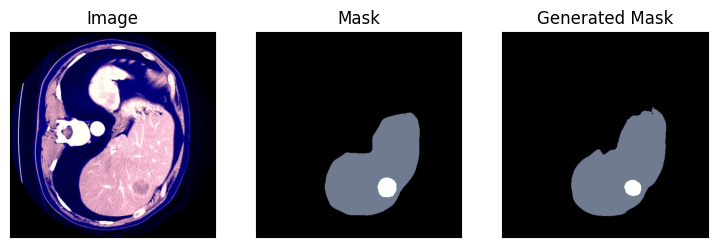

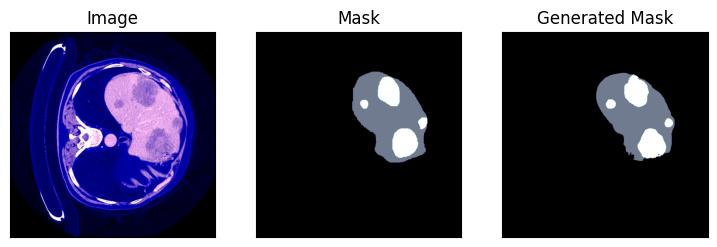

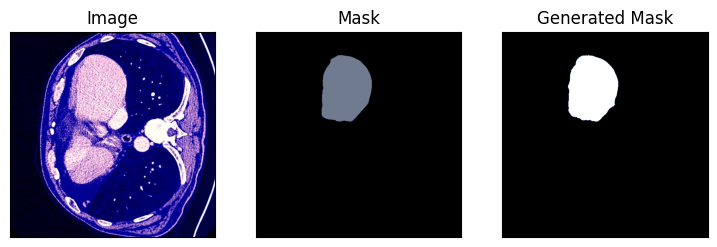

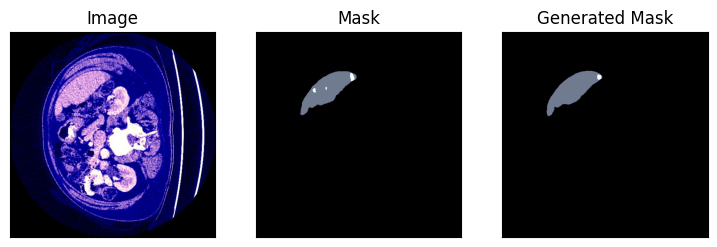

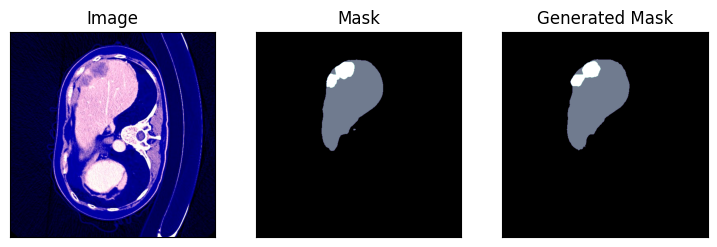

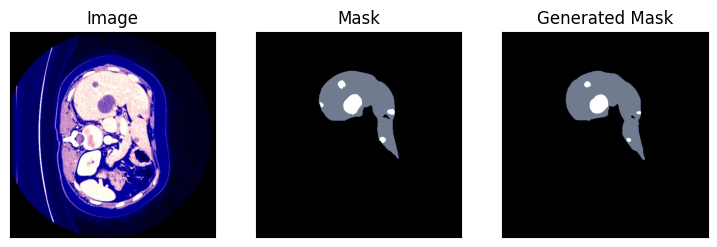

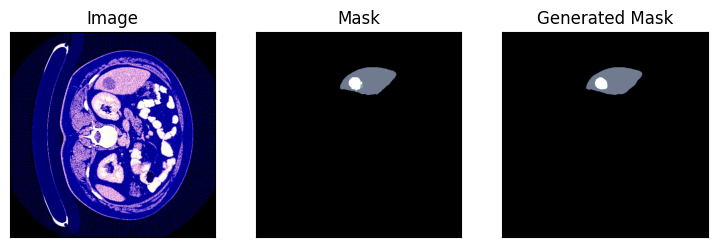

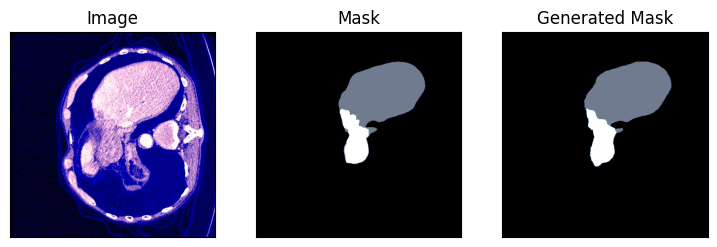

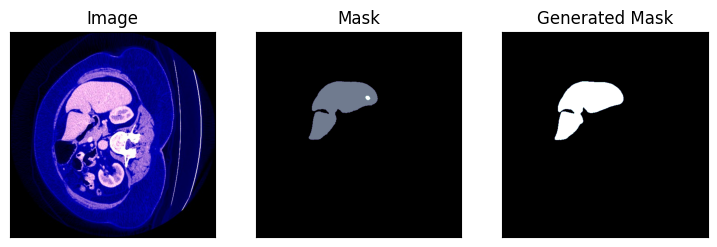

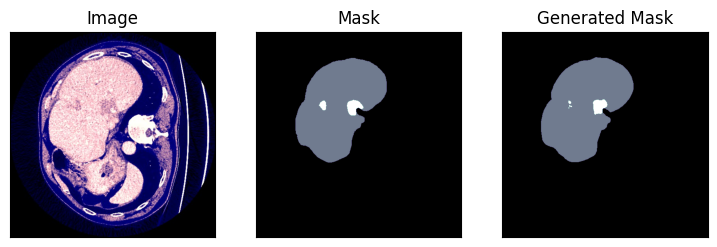

In [28]:
import random

l = random.sample(range(0,1078), 10)


for i in l:
    visualize(image = read_image(valid_x[i]), mask = read_mask(valid_y[i]), generated_mask = read_mask(valid_masks[i]))